# Load and View Data

Number of data points: 200
k in [0, 199]


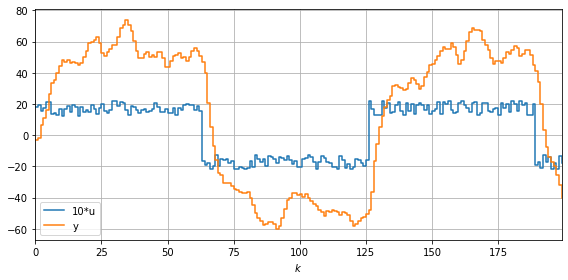

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file = '../data.csv'
data = pd.read_csv(file, header=None, names=['u', 'y'])
N = len(data)

k = data.index.values
u = data.u.values
y = data.y.values

print('Number of data points:', N)
print(f'k in [{k[0]}, {k[-1]}]')

plt.figure(figsize=(8,4))
plt.plot(k, 10*u, label='10*u', drawstyle='steps-post')
plt.plot(k, y   , label='y'   , drawstyle='steps-post')
plt.xlim(k[0], k[-1])
plt.xlabel(r'$k$')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## Input Fourier Transform

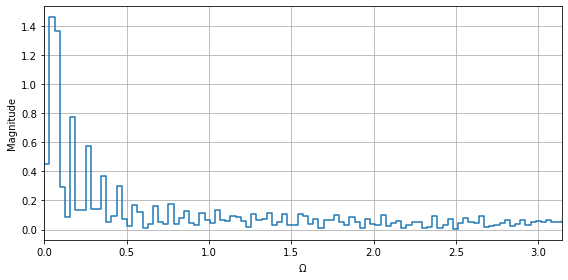

In [2]:
from scipy import fft

u_rfft = fft.rfft(u, norm='forward')
u_rfft[1:-1] = 2*u_rfft[1:-1]

u_rfft_mag = np.abs(u_rfft)
Omega = np.linspace(0, np.pi, len(u_rfft_mag))

plt.figure(figsize=(8,4))
plt.plot(Omega, u_rfft_mag, drawstyle='steps-post')
plt.xlim(Omega[0], Omega[-1])
plt.xlabel(r'$\Omega$')
plt.ylabel('Magnitude')
plt.grid()
plt.tight_layout()
plt.show()

## Separate Identification and Validation Data

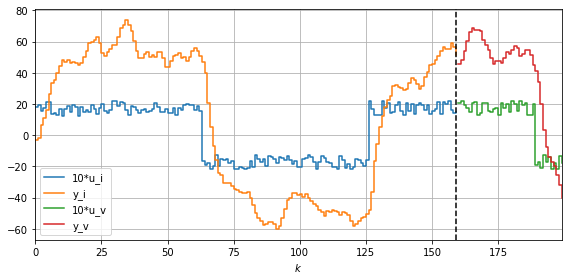

In [3]:
N_fold = 160

k_i = k[:N_fold]
u_i = u[:N_fold]
y_i = y[:N_fold]

k_v = k[N_fold:]
u_v = u[N_fold:]
y_v = y[N_fold:]

plt.figure(figsize=(8,4))
plt.plot(k_i, 10*u_i, label='10*u_i', drawstyle='steps-post')
plt.plot(k_i, y_i   , label='y_i'   , drawstyle='steps-post')
plt.plot(k_v, 10*u_v, label='10*u_v', drawstyle='steps-post')
plt.plot(k_v, y_v   , label='y_v'   , drawstyle='steps-post')
plt.axvline(k[N_fold-1], color='black', linestyle='--')
plt.xlim(k[0], k[-1])
plt.xlabel(r'$k$')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Generic Model

\begin{gather*}
A(q) \, y[k] = \dfrac{B(q)}{F(q)} \, u[k - n_k + 1] + \dfrac{C(q)}{D(q)} \, e[k]
\\
y[k] = G(q) \, u[k - n_k + 1] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{A(q) \, F(q)}
\qquad
H(q) = \dfrac{C(q)}{A(q) \, D(q)}
\\
A(q) = 1 - a_1 \, q^{-1} - \dotsb - a_{n_a} \, q^{-n_a}
\\
B(q) = b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b} + + b_{n_b + 1} \, q^{-n_b-1}
\\
C(q) = 1 + c_1 \, q^{-1} + \dotsb + c_{n_c} \, q^{-n_c}
\\
D(q) = 1 + d_1 \, q^{-1} + \dotsb + d_{n_d} \, q^{-n_d}
\\
F(q) = 1 + f_1 \, q^{-1} + \dotsb + f_{n_f} \, q^{-n_f}
\end{gather*}

In [4]:
from functions import models_frame

models = models_frame()

# ARX

\begin{gather*}
y[k] = G(q) \, u[k - n_k + 1] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{A(q)}
\qquad
H(q) = \dfrac{1}{A(q)}
\\
A(q) = 1 - a_1 \, q^{-1} - \dotsb - a_{n_a} \, q^{-n_a}
\\
B(q) = b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b} + + b_{n_b + 1} \, q^{-n_b-1}
\end{gather*}

In [5]:
from functions import arx

na_range = range(0, 3 + 1)
nb_range = range(0, 2 + 1)
nk_range = range(0, 2 + 1)

models_arx = arx(u_i, y_i, u_v, y_v, na_range, nb_range, nk_range)

models = pd.concat([models, models_arx], ignore_index=True)

# ARMAX

\begin{gather*}
y[k] = G(q) \, u[k - n_k + 1] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{A(q)}
\qquad
H(q) = \dfrac{C(q)}{A(q)}
\\
A(q) = 1 - a_1 \, q^{-1} - \dotsb - a_{n_a} \, q^{-n_a}
\\
B(q) = b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b} + + b_{n_b + 1} \, q^{-n_b-1}
\\
C(q) = 1 + c_1 \, q^{-1} + \dotsb + c_{n_c} \, q^{-n_c}
\end{gather*}

In [6]:
from functions import armax

na_range = range(0, 3 + 1)
nb_range = range(0, 2 + 1)
nc_range = range(0, 3 + 1)
nk_range = range(0, 2 + 1)

models_armax = armax(u_i, y_i, u_v, y_v, na_range, nb_range, nc_range, nk_range)

models = pd.concat([models, models_armax], ignore_index=True)

# Output Error

\begin{gather*}
y[k] = G(q) \, u[k - n_k + 1] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{F(q)}
\qquad
H(q) = 1
\\
B(q) = b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b} + + b_{n_b + 1} \, q^{-n_b-1}
\\
F(q) = 1 + f_1 \, q^{-1} + \dotsb + f_{n_f} \, q^{-n_f}
\end{gather*}

In [7]:
from functions import oe

nb_range = range(0, 2 + 1)
nf_range = range(1, 3 + 1) # nf = 0 causa erro no pysid!
nk_range = range(0, 2 + 1)

models_oe = oe(u_i, y_i, u_v, y_v, nb_range, nf_range, nk_range)

models = pd.concat([models, models_oe], ignore_index=True)

# Box-Jenkins

\begin{gather*}
y[k] = G(q) \, u[k - n_k + 1] + H(q) \, e[k]
\\
G(q) = \dfrac{B(q)}{F(q)}
\qquad
H(q) = \dfrac{C(q)}{D(q)}
\\
B(q) = b_1 \, q^{-1} + \dotsb + b_{n_b} \, q^{-n_b} + + b_{n_b + 1} \, q^{-n_b-1}
\\
C(q) = 1 + c_1 \, q^{-1} + \dotsb + c_{n_c} \, q^{-n_c}
\\
D(q) = 1 + d_1 \, q^{-1} + \dotsb + d_{n_d} \, q^{-n_d}
\\
F(q) = 1 + f_1 \, q^{-1} + \dotsb + f_{n_f} \, q^{-n_f}
\end{gather*}

In [8]:
from functions import bj

nb_range = range(0, 2 + 1)
nc_range = range(0, 3 + 1)
nd_range = range(0, 3 + 1)
nf_range = range(0, 3 + 1)
nk_range = range(0, 2 + 1)

models_bj = bj(u_i, y_i, u_v, y_v, nb_range, nc_range, nd_range, nf_range, nk_range)

models = pd.concat([models, models_bj], ignore_index=True)

d:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:118: RuntimeWarning: overflow encountered in multiply
  suf = s * uf
d:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:513: RuntimeWarning: invalid value encountered in double_scalars
  actual_reduction = cost - cost_new
d:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:112: RuntimeWarning: overflow encountered in square
  denom = s**2 + alpha
d:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:113: RuntimeWarning: invalid value encountered in true_divide
  p_norm = norm(suf / denom)
d:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: invalid value encountered in true_divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
d:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:161: RuntimeWarning: overflow encountered in square
  p = -V.dot(suf / (s**2 + alpha))
d:\ProgramData\Anaconda3\li

# Results

## Sort by Prediction Cost

In [9]:
models.sort_values(by=['Jp'], inplace=True)

## Display Predictions

TransferFunction(array([2.68814128, 0.        , 0.        ]), array([ 1.        , -1.56321742,  0.89515865, -0.23728454]), True)

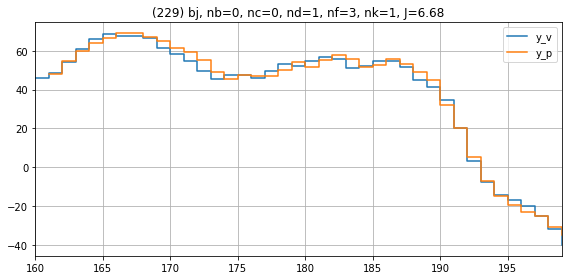

TransferFunction(array([2.34782822, 5.09652727, 2.65725783]), array([ 1.        ,  0.14429035, -0.78392927,  0.        ]), True)

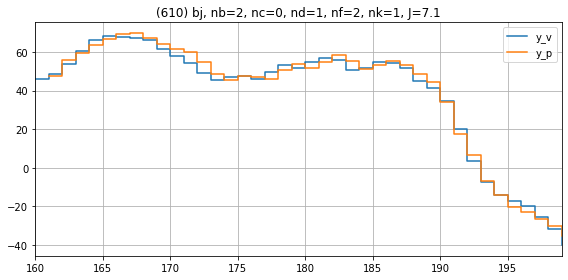

TransferFunction(array([2.34429622, 2.82552041]), array([ 1.        , -0.81537418,  0.        ]), True)

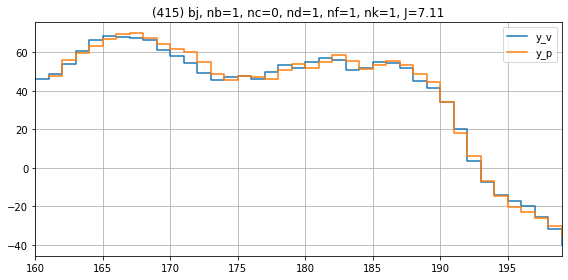

TransferFunction(array([ 2.34444798,  2.83182598, -0.01857828]), array([ 1.       , -0.8159165,  0.       ,  0.       ]), True)

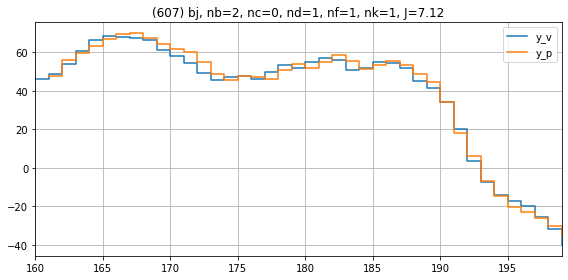

TransferFunction(array([2.34448303, 2.85262294]), array([ 1.        , -0.80784587, -0.00669022]), True)

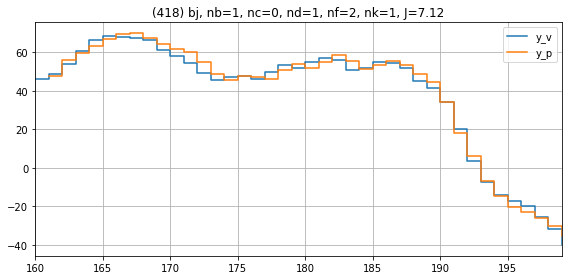

TransferFunction(array([2.33100339, 3.04023613, 0.        ]), array([ 1.        , -0.72919919, -0.13884075,  0.06154987]), True)

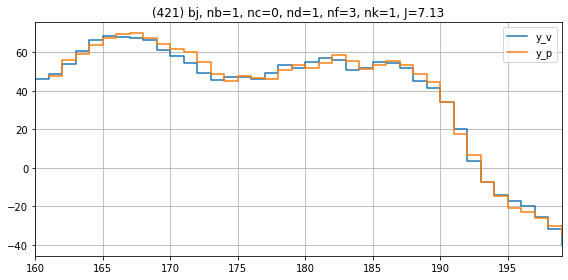

TransferFunction(array([ 2.3308263 ,  2.83862053, -0.26281379]), array([ 1.        , -0.81694484, -0.06953569,  0.06343096]), True)

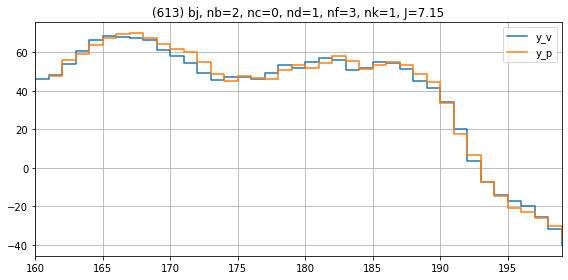

TransferFunction(array([2.66259961]), array([ 1.        , -1.36604553,  0.4621642 ]), True)

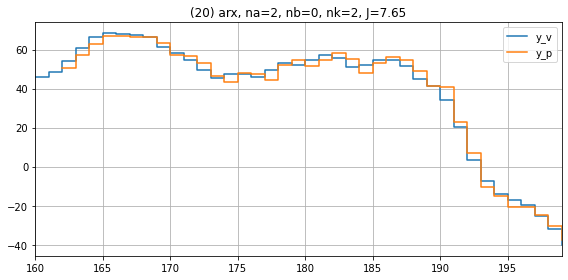

TransferFunction(array([2.67814901]), array([ 1.        , -1.36212238,  0.45875524]), True)

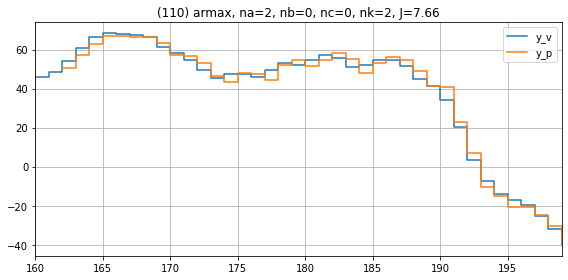

TransferFunction(array([2.54959448, 0.        ]), array([ 1.        , -1.38732955,  0.4880542 , -0.00845539]), True)

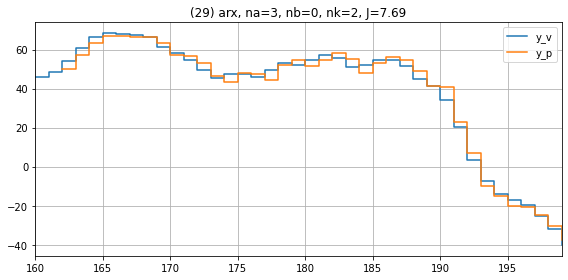

TransferFunction(array([ 3.26679552, -1.51265961]), array([ 1.        , -1.46412481,  0.52854002,  0.        ]), True)

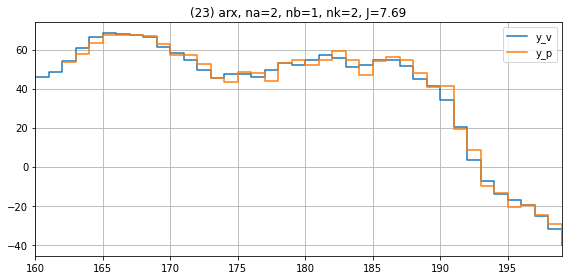

TransferFunction(array([2.67890632, 0.        ]), array([ 1.        , -1.37210758,  0.48234395, -0.01371625]), True)

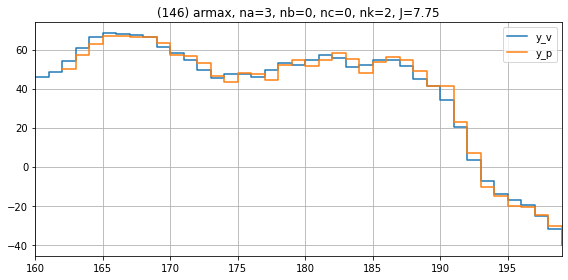

TransferFunction(array([ 3.3750427 , -1.58562544]), array([ 1.        , -1.46000962,  0.5255264 ,  0.        ]), True)

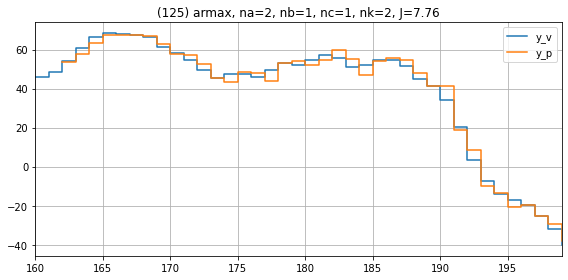

TransferFunction(array([ 3.37317833, -1.55387021]), array([ 1.        , -1.45272069,  0.51926335,  0.        ]), True)

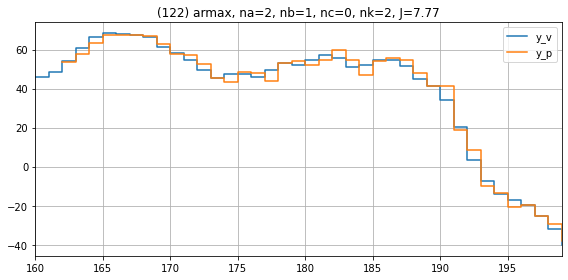

TransferFunction(array([3.01159191, 0.        ]), array([ 1.        , -1.30207228,  0.41403272]), True)

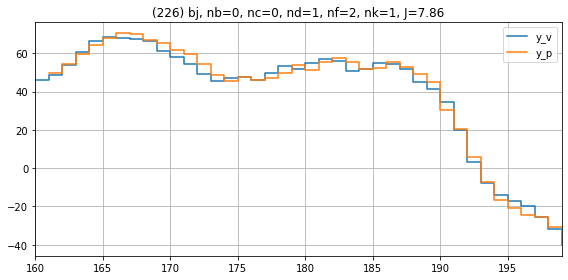

TransferFunction(array([ 3.29881935, -1.59754406]), array([ 1.        , -1.43386469,  0.44808493,  0.04884435]), True)

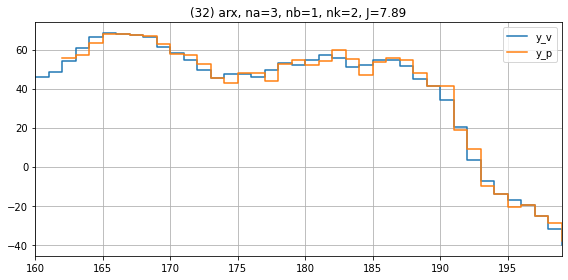

TransferFunction(array([ 3.40955305, -1.64114662]), array([ 1.        , -1.4226945 ,  0.43970782,  0.04823574]), True)

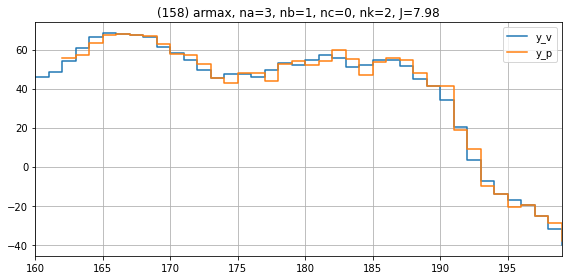

TransferFunction(array([ 3.25266499, -1.77050613,  0.4761475 ]), array([ 1.        , -1.46463045,  0.52812529,  0.00838661,  0.        ]), True)

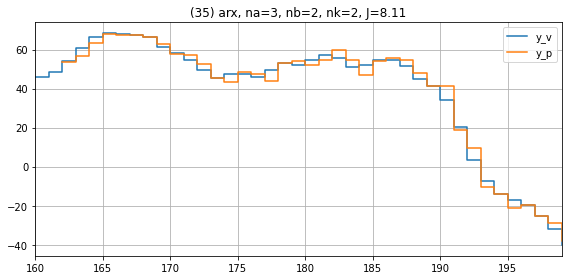

TransferFunction(array([ 3.24561534, -1.76727531,  0.49629534]), array([ 1.        , -1.47010956,  0.54248854,  0.        ,  0.        ]), True)

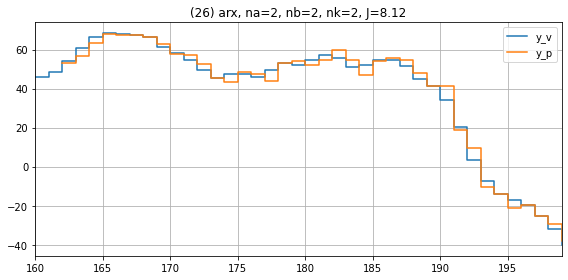

TransferFunction(array([ 3.33926659, -1.89385289,  0.52761024]), array([ 1.        , -1.45037672,  0.50669681,  0.01609173,  0.        ]), True)

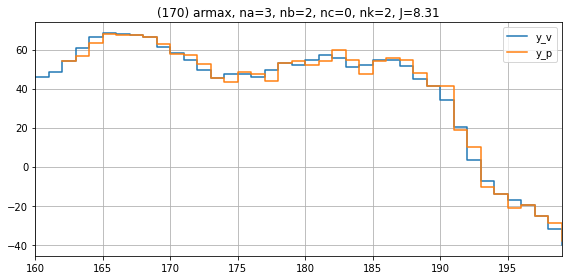

TransferFunction(array([ 3.33364023, -1.96773675,  0.57519141]), array([ 1.        , -1.47571728,  0.54691163,  0.        ,  0.        ]), True)

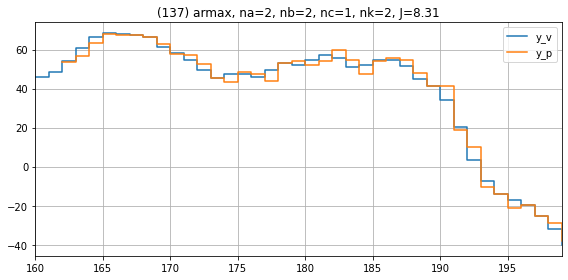

In [12]:

for i, (index, model) in enumerate(models.iterrows()):
  if i > 20:
    break

  if np.isnan(model.yp).any():
    continue

  if model.model == 'arx':
    title = f'({index}) {model.model}, na={model.na}, nb={model.nb}, nk={model.nk}, J={model.Jp:.3g}'
  elif model.model == 'armax':
    title = f'({index}) {model.model}, na={model.na}, nb={model.nb}, nc={model.nc}, nk={model.nk}, J={model.Jp:.3g}'
  elif model.model == 'oe':
    title = f'({index}) {model.model}, nb={model.nb}, nf={model.nf}, nk={model.nk}, J={model.Jp:.3g}'
  elif model.model == 'bj':
    title = f'({index}) {model.model}, nb={model.nb}, nc={model.nc}, nd={model.nd}, nf={model.nf}, nk={model.nk}, J={model.Jp:.3g}'
  else:
    assert(False)

  display(model.G)

  plt.figure(figsize=(8,4))
  plt.title(title)
  plt.plot(k_v, y_v, label='y_v', drawstyle='steps-post')
  plt.plot(k_v[model.nk:], model.yp, label='y_p', drawstyle='steps-post')
  plt.xlim(k_v[0], k_v[-1])
  plt.grid()
  plt.legend()
  plt.tight_layout()
  plt.show()

TransferFunction(array([ 2.16246556,  1.61084338, -1.6016382 ]), array([ 1.        , -1.40683412,  0.48261202,  0.        ]), True)

TransferFunction(array([1., 0., 0.]), array([ 1.        , -1.40683412,  0.48261202]), True)

16.155434149353134

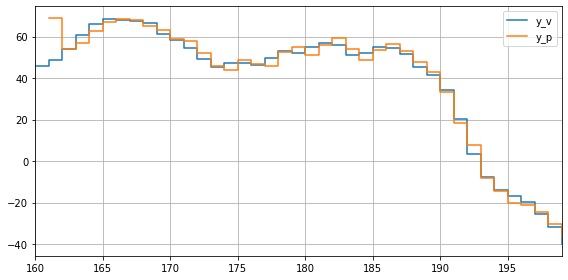

In [16]:
model = models.loc[(models.model == 'arx') & (models.na == 2) & (models.nb == 2) & (models.nk == 1)]
assert(len(model) == 1)
model = model.iloc[0]

display(model.G)
display(model.H)
display(model.Jp)

plt.figure(figsize=(8,4))
plt.plot(k_v, y_v, label='y_v', drawstyle='steps-post')
plt.plot(k_v[model.nk:], model.yp, label='y_p', drawstyle='steps-post')
plt.xlim(k_v[0], k_v[-1])
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()